In [3]:
from pylab import *
from numpy.linalg import norm
import pymc

%matplotlib inline

In [231]:
def get_SI(name):
    phys_constants = {
    'aEarthSun': 1.5 * 10**11, # meters
    'eEarth': 0.06, 
    'mEarth': 5.97 * 10**24, # kg
    'mSun': 1.99 * 10**30, # kg	
    'mNeutronStar': 1.4 * 1.99e30, # kg
    'G': 6.67 * 10**-11
    }
    return phys_constants[name]

def gen_ellipse_X(a, e, phi_array):
    b = a * np.sqrt(1 - e**2)
    X = np.zeros([len(phi_array), 3]) # 3 dimensions, but the z will all be 0 for orbit in the plane.
    X[:,0] = a * np.cos(phi_array) +  a * e
    X[:,1] = b * np.sin(phi_array)
    return X

def gen_ellipse_V_dir(a, e, phi_array):
    b = a * np.sqrt(1 - e**2)
    nRows = 1 if type(phi_array)==float else len(phi_array)
    V_dir = np.zeros([nRows, 3])
    V_dir[:,0] = -a * np.sin(phi_array)
    V_dir[:,1] = b * np.cos(phi_array)
    normalization_vec = 1/norm(V_dir, axis=1)
    V_dir = (V_dir.T * normalization_vec).T
    return V_dir

def orbital_speed(r, a, m1, m2):
    mu = m1 * m2 /(m1 + m2)
    G = 6.67 * 10**-11
    return np.sqrt(G * (m1 + m2) * (2/r - 1/a))
orbital_speed = np.vectorize(orbital_speed)

def gen_V_vec(phi_array, a, e, m1, m2):
    V_dir = gen_ellipse_V_dir(a, e, phi_array)
    X = gen_ellipse_X(a, e, phi_array=phi_array)
    speeds = orbital_speed(r=norm(X, axis=1), a=a, m1=m1, m2=m2)
    return (V_dir.T * speeds).T


def is_orbit_bound(m1, m2, X, V):
    speed = np.linalg.norm(V)
    mu = m1 * m2 / (m1 + m2)
    KE = 0.5 * mu * speed**2
    
    G = 6.67e-11
    r = np.linalg.norm(X)
    U = -(G * m1 * m2) / r
    
    return KE + U < 0
#is_orbit_bound = np.vectorize(is_orbit_bound)

# given bodies m and M with relative position and velocity r_vec and v_vec,
# return the semi-major axis and eccentricity of this orbit. 
def NewAE(m, M, r_vec, v_vec):
    mu = (m * M) / (m + M)												# reduced mass.
    E = - ((G * m * M) / np.linalg.norm(r_vec) + (0.5) *	# energy. 
        mu * np.linalg.linalg.dot(v_vec, v_vec))
    a = - (G * m * M) / (2 * E)				# semi-major axis.
    J = mu * np.cross(r_vec, v_vec)		# angular momentum.
    e = np.sqrt(1 - (np.linalg.norm(J)**2)/(mu**2 * (m + M) * G * a)) # eccentricity
    return a, e

# Generates a uniformly random point on the unit sphere. I found this algorithm 
# at http://mathworld.wolfram.com/SpherePointPicking.html . Or try googling
# 'random point on unit sphere'.
def generate_random_N_unit_3_vecs(N):
    # generate two random numbers on (-1, 1); skip those where
    # u**2 + v**2 >= 1.
    u, v = 100, 100
    while u**2 + v**2 >= 1:
        try:
            u = (np.random.random() - 0.5) * 2
            v = (np.random.random() - 0.5) * 2
        except ValueError as e:
            print e, "u = {}, v = {}".format(u, v)
    # compute xyz coordinates
    x = 2 * u * math.sqrt(1 - u**2 - v**2)
    y = 2 * v * math.sqrt(1 - u**2 - v**2)
    z = 1 - 2 * (u**2 + v**2)
    return np.array([x, y, z])

def gen_N_random_kicks(N, maxwell_mu=1.9e5):
    Nx3_gaussian_array = np.array([
        np.random.normal(loc=0.0, scale=1.0, size=N),
        np.random.normal(loc=0.0, scale=1.0, size=N),
        np.random.normal(loc=0.0, scale=1.0, size=N)
    ]).T
    a = maxwell_mu / (2 * np.sqrt(2/np.pi)) # see http://mathworld.wolfram.com/MaxwellDistribution.html
    kickspeeds = scipy.stats.maxwell.rvs(scale=a, size=N)
    normalization_vec = 1/norm(Nx3_gaussian_array, axis=1) # see http://mathworld.wolfram.com/HyperspherePointPicking.html
    N_unit_vectors = (Nx3_gaussian_array.T * normalization_vec).T
    N_kick_vectors = (N_unit_vectors.T * kickspeeds).T
    return N_kick_vectors

# assumes eccentricity is 0. 
def get_percent_retained(N, a, m1=1e25, m2i = 7e30, m2f=4e30):
    phi_array = np.array([0])
    Xi = gen_ellipse_X(a=a, e=0,phi_array=phi_array)
    Xi_N_clones = np.repeat(Xi, N, axis=0)
    Vi = gen_V_vec(a=a, e=0, m1=m1, m2=m2i, phi_array=phi_array)
    Vi_N_clones = np.repeat(Vi, N, axis=0)
    V_kick_vecs = gen_N_random_kicks(N)
    Vf_vecs = Vi_N_clones - V_kick_vecs
    retained_or_not = np.zeros(N)
    for i in range(int(N)):
        retained_or_not[i] = is_orbit_bound(m1, m2f, Xi_N_clones[i], Vf_vecs[i])
    
    return sum(retained_or_not)/N




In [232]:
#starttime = time.time()
#NN =  1e5
#a = get_percent_retained(N=NN, a=2e11)
#print(sum(a)/NN)
#fig = figure(figsize=(8,8)); hist(norm(a, axis=1)); axvline(1.9e5, c='r')
#print('{} sec/N'.format((time.time() - starttime)/NN))

oneAU = 1.5 * 1e11 # meters
earthMass = 6 * 1e24 # kg
a_range = np.linspace(start= 1 * oneAU, stop= 10 * oneAU, num=50)
m1_range = np.linspace(start= 1 * earthMass, stop= 1e29, num=10)
retained = np.zeros((len(a_range), len(m1_range)))
N = int(1e4)
for i in range(len(a_range)):
    print(i)
    for j in range(len(m1_range)):
        retained[i][j] = get_percent_retained(N=N, a=a_range[i], m1=m1_range[j])



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [217]:
m1_range

array([  6.00000000e+24,   6.72000000e+26,   1.33800000e+27,
         2.00400000e+27,   2.67000000e+27,   3.33600000e+27,
         4.00200000e+27,   4.66800000e+27,   5.33400000e+27,
         6.00000000e+27])

((50, 10), (50, 10), (50, 10))


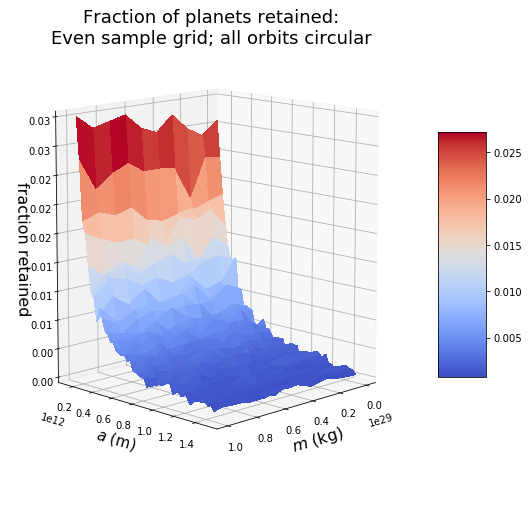

In [247]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize=(9,9))
ax = fig.gca(projection='3d')



# Make data.
Y = a_range
X = m1_range
X, Y = np.meshgrid(X, Y)
print(X.shape, Y.shape, retained.shape)
#R = np.sqrt(X**2 + Y**2)
#Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, retained, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlabel('$m$ (kg)', fontsize=16)
ax.set_ylabel('$a$ (m) ', fontsize=15)
ax.set_zlabel('fraction retained', fontsize=16)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=10., azim=45)
ax.set_title('Fraction of planets retained:\nEven sample grid; all orbits circular', fontsize=18)
fig.savefig('surface_retained.png')

#plt.show()

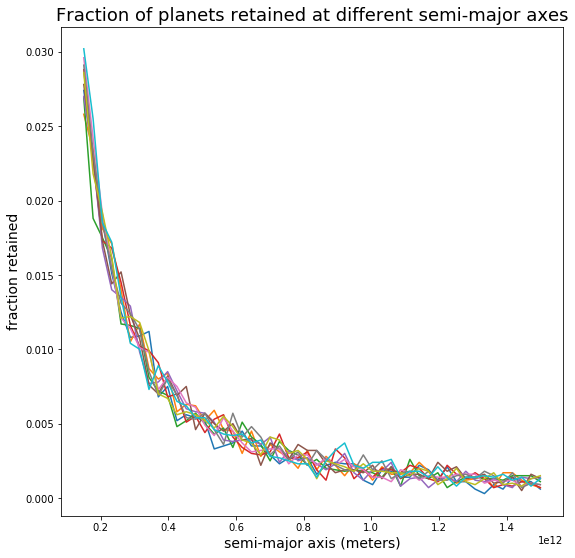

In [240]:

fig = figure(figsize=(9,9))
plot(a_range, retained)

title('Fraction of planets retained at different semi-major axes', fontsize=18)
xlabel('semi-major axis (meters)', fontsize=14); ylabel('fraction retained', fontsize=14)
savefig('even_a', dpi=300)

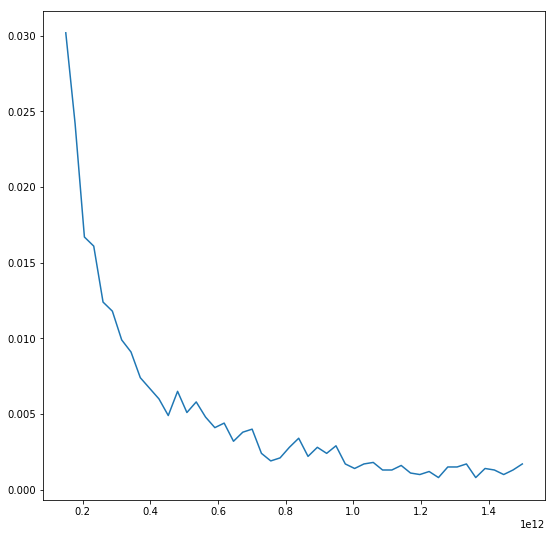

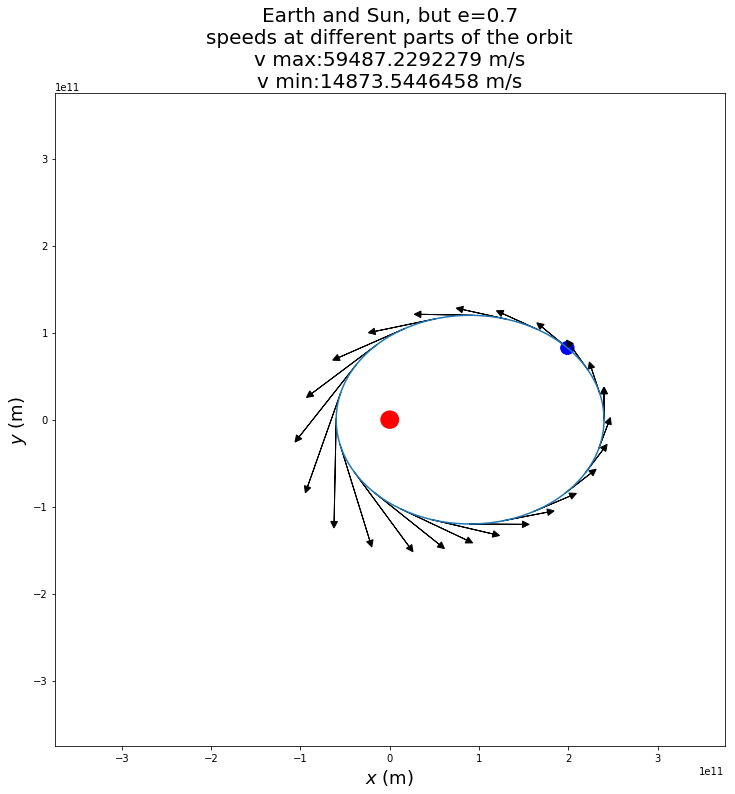

In [38]:
# For a basic test, plot the velocities at several points around an orbit. 

def draw_orbit(steps, a=None, e=None, m1=None, m2=None):
    phi_1rev = np.linspace(0, 2*np.pi, 200)
    if not a:
        a = get_SI('aEarthSun')
    if not e:
        e = 0.6
    X = gen_ellipse_X(a, e, phi_1rev)
    V_dir = gen_ellipse_V_dir(a, e, phi_1rev)
    speeds = orbital_speed(norm(X, axis=1), a=a, m1=get_SI('mEarth'), m2=get_SI('mSun'))

    fig1 = figure(figsize=(12, 12))
    circle_star = Circle((0, 0), get_SI('aEarthSun')/15, color='r')
    circle_planet = Circle((X.T[0][24], X.T[1][24]), get_SI('aEarthSun')/20, color='b')
    ax = fig1.gca(); ax.add_artist(circle_star); ax.add_artist(circle_planet)
    plot(X.T[0], X.T[1])
    arrow_indices = np.linspace(0, len(V_dir)-1, steps).astype(int)
    SC = 2e6 # scaling constant.
    for i in arrow_indices:
        arrow(X.T[0][i], X.T[1][i], 
              SC * speeds[i] * V_dir.T[0][i], SC * speeds[i] * V_dir.T[1][i], 
              head_width=a / 20., head_length=a/20., fc='k', ec='k')

    C = 2.5    
    xlim([-a * C,a * C]), ylim([-a * C, a * C])
    xlabel('$x$ (m)', fontsize=(18)); ylabel('$y$ (m)', fontsize=(18))
    title('Earth and Sun, but e=0.7\nspeeds at different parts of the orbit\nv max:{} m/s\nv min:{} m/s'.format(
        speeds.max(), speeds.min()), 
          fontsize=20)
    savefig('fig1')

    #fig2 = figure(figsize=(6,6))
    #plot( range(len(X)), norm(X, axis=1))
    #title('r(t)')
    #xlabel('time (non units)'); ylabel('r (meters)')


    #fig3 = figure(figsize=(6,6))
    #plot(range(len(X)), speeds)
    #title('speed (m/s)'); ylabel('speed m/s'); xlabel('phase')

draw_orbit(steps=25, a=None, e=None, m1=None, m2=None)

|v kick|:[   2347.29126057 -106174.24765675       0.        ]


/Users/aaron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in double_scalars


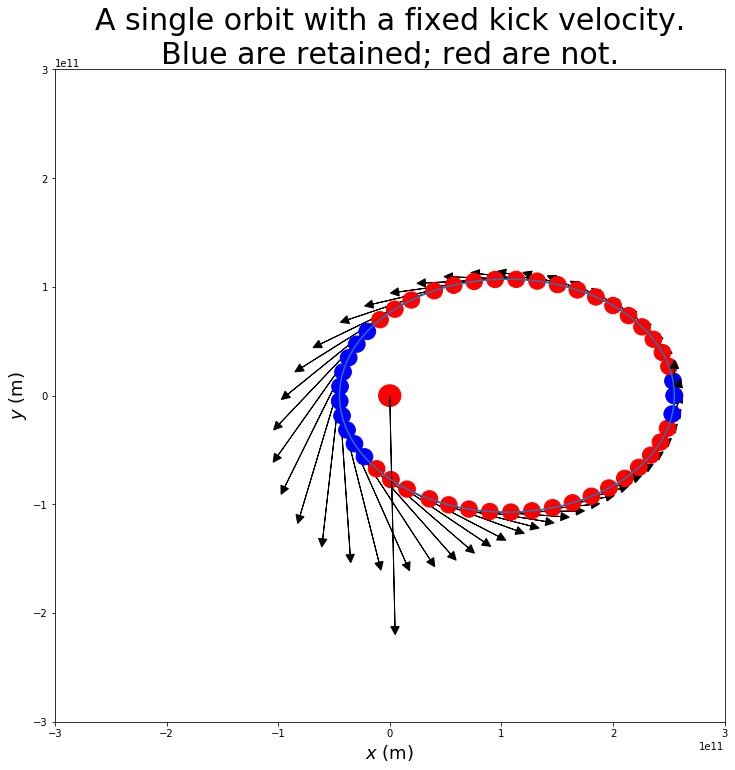

In [37]:
# Now, adding in kick velocity and marking where in the orbit the planet remains orbitally bound. 


def plot_kick_retention(e=0):
    phi_1rev = np.linspace(0, 2*np.pi, 200)
    a = get_SI('aEarthSun')
    X = gen_ellipse_X(a, e, phi_1rev)
    V_dir = gen_ellipse_V_dir(a, e, phi_1rev)
    speeds = orbital_speed(norm(X, axis=1), a=a, m1=get_SI('mEarth'), m2=get_SI('mSun'))
    V_vec = gen_V_vec(phi_array=phi_1rev, a=a, e=e, m1=get_SI('mSun'), m2=get_SI('mEarth'))

    # choose a kick velocity similar to an orbital speed
    C = 1.5
    V_kick = C * V_vec[int(len(V_vec)/2)]; print('|v kick|:{}'.format(V_kick))
    new_V_vec = V_vec - np.ones([3, ])
    is_orbit_bound_array = is_orbit_bound(m1=get_SI('mEarth'), m2=get_SI('mSun'), 
                          X=X, V=V_vec - V_kick).T[1]

    fig1 = figure(figsize=(12, 12))

    # actual orbit shape.
    plot(X.T[0], X.T[1])

    circle_star = Circle((0, 0), get_SI('aEarthSun')/15, color='r')
    ax = fig1.gca(); ax.add_artist(circle_star); 
    arrow_indices = np.linspace(0, len(V_dir)-1, 50).astype(int)
    SC = 2e6 # scaling constant.
    for i in arrow_indices:
        arrow(X.T[0][i], X.T[1][i], 
              SC * V_vec.T[0][i], SC * V_vec.T[1][i], 
              head_width=a / 20., head_length=a/20., fc='k', ec='k')
        if is_orbit_bound_array[i]:
            circle_planet = Circle((X.T[0][i], X.T[1][i]), get_SI('aEarthSun')/20, color='b')
            ax.add_artist(circle_planet)
        else:
            circle_planet = Circle((X.T[0][i], X.T[1][i]), get_SI('aEarthSun')/20, color='r')
            ax.add_artist(circle_planet)
    # draw the kick velocity 
    arrow(0, 0, SC * V_kick[0], SC * V_kick[1], 
          head_width=a / 20., head_length=a/20., fc='k', ec='k')

    C = 2.0    
    xlim([-a * C,a * C]), ylim([-a * C, a * C])
    xlabel('$x$ (m)', fontsize=(18)); ylabel('$y$ (m)', fontsize=(18))
    title('A single orbit with a fixed kick velocity.\nBlue are retained; red are not.'.format(
        speeds.max(), speeds.min()), 
          fontsize=30)
    savefig('retentionillustration', dpi=300)

    #fig2 = figure(figsize=(6,6))
    #plot( range(len(X)), norm(X, axis=1))
    #title('r(t)')
    #xlabel('time (non units)'); ylabel('r (meters)')


    #fig3 = figure(figsize=(6,6))
    #plot(range(len(X)), speeds)
    #title('speed (m/s)'); ylabel('speed m/s'); xlabel('phase')

In [55]:
import scipy
import time

def test_speed(N):
    N = int(N)
    #numbers = np.zeros(N)
    start_time = time.time()
    #for i in range(N):
    #numbers[i] =  scipy.stats.maxwell.rvs(scale=1)
    
    vectors = np.zeros([N, 3])
    for i in range(N):
        vectors[i] = generate_random_unit_3_vec()
    
    time_delta = time.time() - start_time
    print('took {} seconds to do {} randoms\n meaning {} sec/random'.format(time_delta, N, time_delta/N))
    return vectors
    
print(test_speed(1e3)[:10])

took 0.0129840373993 seconds to do 1000 randoms
 meaning 1.29840373993e-05 sec/random
[[ 0.67024033 -0.43181422  0.60358461]
 [ 0.02028208 -0.85865798 -0.51214756]
 [ 0.51323065 -0.41848886 -0.74930727]
 [-0.6709328  -0.01456718  0.74137506]
 [ 0.7526062   0.46319546 -0.46801055]
 [-0.6800589  -0.71141366 -0.17723007]
 [-0.75138311  0.44603942  0.48628413]
 [-0.80142386  0.4820274   0.35407539]
 [-0.05131929 -0.4745236  -0.87874552]
 [-0.91097261  0.37800214  0.16505543]]


In [128]:
a = np.random.random([2,2])

def gen_N_random_kicks(N, maxwell_mu=1.9e5, c='r'):
    Nx3_gaussian_array = np.array([
        np.random.normal(loc=0.0, scale=1.0, size=N),
        np.random.normal(loc=0.0, scale=1.0, size=N),
        np.random.normal(loc=0.0, scale=1.0, size=N)
    ]).T
    a = maxwell_mu / (2 * np.sqrt(2/np.pi)) # see http://mathworld.wolfram.com/MaxwellDistribution.html
    kickspeeds = scipy.stats.maxwell.rvs(scale=a, size=N)
    normalization_vec = 1/norm(Nx3_gaussian_array, axis=1) # see http://mathworld.wolfram.com/HyperspherePointPicking.html
    N_unit_vectors = (Nx3_gaussian_array.T * normalization_vec).T
    N_kick_vectors = (N_unit_vectors.T * kickspeeds).T
    return N_kick_vectors
    
starttime = time.time()
NN =  1e6
a = gen_N_random_kicks(N=int(NN))
#fig = figure(figsize=(8,8)); hist(norm(a, axis=1)); axvline(1.9e5, c='r')
print('{} sec/N'.format((time.time() - starttime)/NN))

3.33492040634e-07 sec/N


In [184]:
print(1e1)

10.0


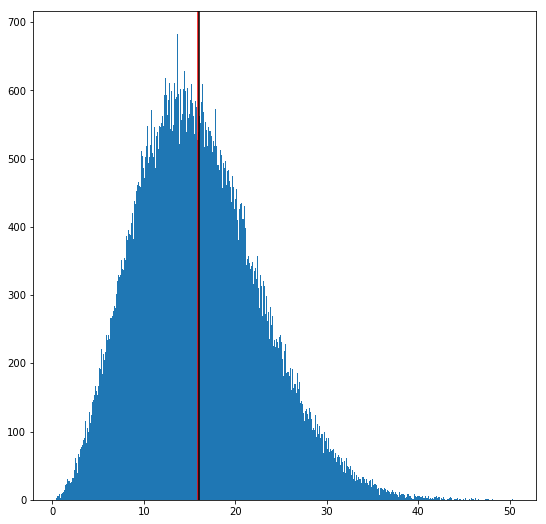

In [97]:
kickspeeds = scipy.stats.maxwell.rvs(loc=0, scale=10, size=100000)
fig=figure(figsize=(9,9))
binwidth = 0.1
hist(kickspeeds, bins=np.arange(min(kickspeeds), max(kickspeeds) + binwidth, binwidth));
axvline(10 * 2 * np.sqrt(2./np.pi), c='r')
axvline(kickspeeds.mean(), c='k')
